# PiML Toolbox: High-code Demo for CaliforniaHousing Data

This example notebook demonstrates how to use PiML with its high-code APIs for developing machine learning models for the CaliforniaHousing data, which consists of 20,640 samples and 9 features, fetched by sklearn.datasets (see details here). PiML can load three versions of this data, including _raw, _trim1 (trimming only AveOccup) and _trim2 (trimming AveRooms, AveBedrms, Population and AveOccup). The _trim2 version is used in this example.

The response MedHouseVal (median house price per block in log scale) is continuous and it is a regression problem.

# Stage 0: Install PiML package on Google Colab

1. Run `!pip install piml` to install the latest version of PiML. It requires V0.2 or above to use high-code APIs.
2. In Colab, you'll need restart the runtime in order to use newly installed PiML version.

In [1]:
!pip install piml

In [2]:
from piml import Experiment
exp = Experiment(highcode_only=True)

# Stage 1: Initialize an experiment, Load and Prepare data

In [3]:
exp.data_loader(data='CaliforniaHousing_trim2')

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [4]:
exp.data_summary(feature_exclude=[])

HTML(value='Data Shape:(20640, 9)')

In [5]:
exp.data_prepare(target='MedHouseVal', task_type='Regression', test_ratio=0.2, random_state=0)

,Config,Value
0,Excluded columns,[]
1,Target variable,MedHouseVal
2,Sample weight,None
3,Task type,Regression
4,Split method,Random
5,Test ratio,0.2
6,Random state,0
7,Train test energy distance,0.000258


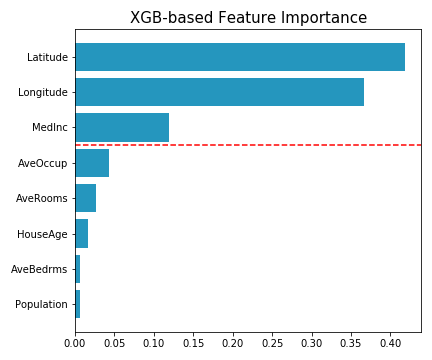

In [6]:
exp.feature_select(method="pfi", threshold=0.9, figsize=(6, 5))

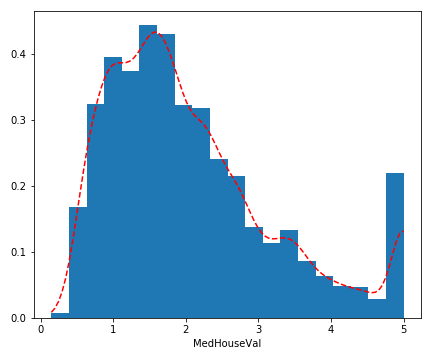

In [7]:
exp.eda(show='univariate', uni_feature='MedHouseVal', figsize=(6, 5))

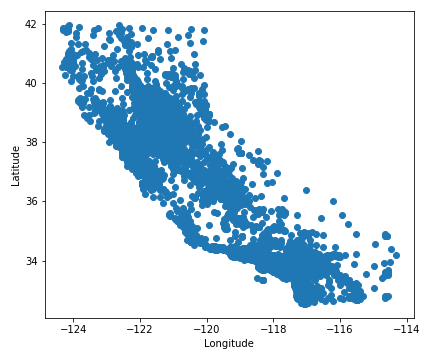

In [8]:
exp.eda(show='bivariate', bi_features=['Longitude', 'Latitude'], figsize=(6, 5))

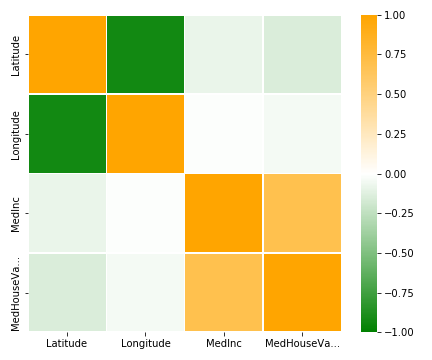

In [9]:
exp.eda(show='multivariate', multi_type='correlation_heatmap', figsize=(6, 5))

# Stage 2. Train intepretable models  

In [10]:
## ReLU-DNN: ReLU Deep Neural Networks with L1-Regularization
from piml.models import ReluDNNRegressor

clf1 = ReluDNNRegressor(hidden_layer_sizes=(40, 40), l1_reg=1e-05,
                        batch_size=500, learning_rate=0.001)
exp.model_train(model=clf1, name='ReLU-DNN')
exp.model_diagnose(model="ReLU-DNN", show='accuracy_table')

,MSE,MAE,R2
,,,
Train,0.0156,0.0873,0.7255
Test,0.0158,0.0882,0.7149
Gap,0.0002,0.0009,-0.0106


In [11]:
## GAMI-Net: GAM-Neural Networks with Structured Interactions
from piml.models import GAMINetRegressor

clf2 = GAMINetRegressor(interact_num=10, loss_threshold=0.01,  
                        subnet_size_main_effect=[20], 
                        subnet_size_interaction=[20,20])
exp.model_train(model=clf2, name='GAMI-Net')
exp.model_diagnose(model="GAMI-Net", show='accuracy_table')

,MSE,MAE,R2
,,,
Train,0.0169,0.0908,0.7024
Test,0.0174,0.0922,0.6865
Gap,0.0004,0.0014,-0.0159


In [12]:
## EBM: Explainable Boosting Machine from MS Research
from piml.models import ExplainableBoostingRegressor

clf3 = ExplainableBoostingRegressor(interactions=10, random_state=0)
exp.model_train(model=clf3, name='EBM')
exp.model_diagnose(model="EBM", show='accuracy_table')

,MSE,MAE,R2
,,,
Train,0.0142,0.0841,0.7501
Test,0.0144,0.0844,0.7408
Gap,0.0001,0.0003,-0.0092


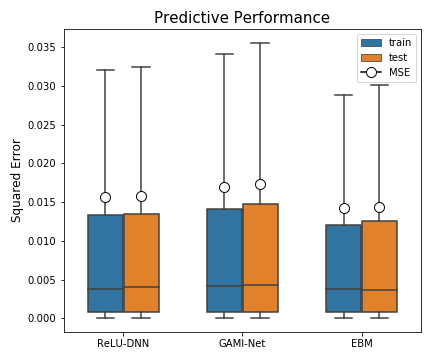

In [13]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='accuracy_plot', metric="MSE", figsize=(6, 5))

# Stage 3. Explain and Interpret

## Post-hoc Explaination: Global and Local Methods 

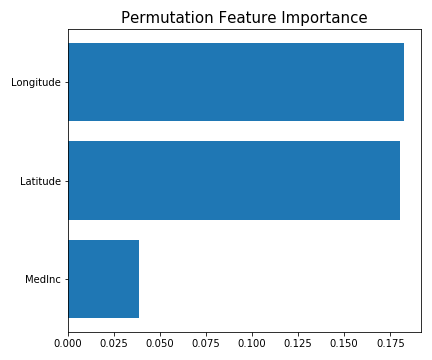

In [14]:
exp.model_explain(model='GAMI-Net', show='pfi', figsize=(6, 5))

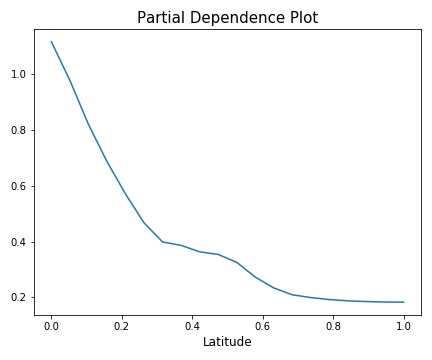

In [15]:
exp.model_explain(model='GAMI-Net', show='pdp', uni_feature='Latitude', figsize=(6, 5))

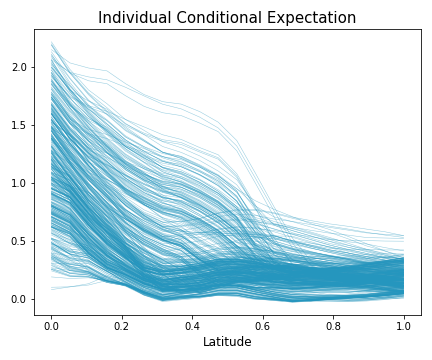

In [16]:
exp.model_explain(model='GAMI-Net', show='ice', uni_feature='Latitude', figsize=(6, 5))

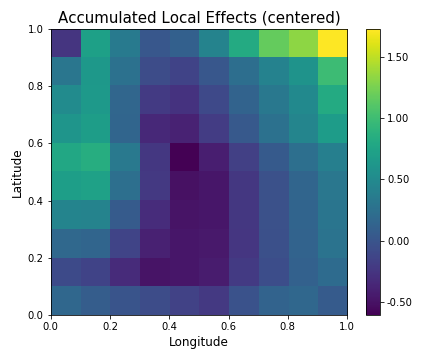

In [17]:
exp.model_explain(model='GAMI-Net', show='ale', bi_features=['Longitude', 'Latitude'], figsize=(6, 5))

Exact explainer: 21it [00:12,  1.59it/s]                                                                               


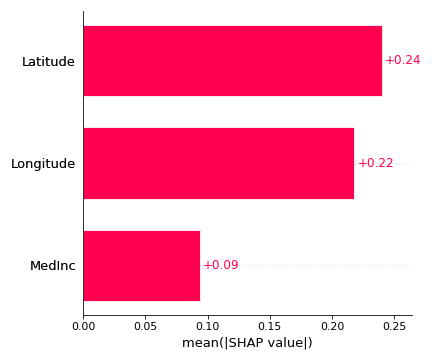

In [18]:
exp.model_explain(model='GAMI-Net', show='shap_fi', sample_size=20, figsize=(6, 5))

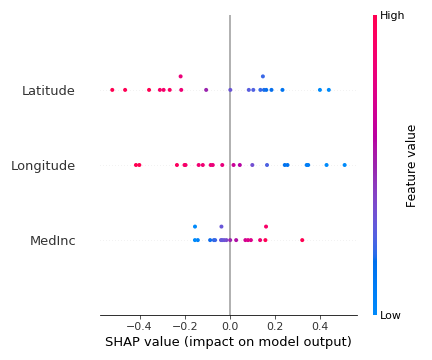

In [19]:
exp.model_explain(model='GAMI-Net', show='shap_summary', sample_size=20, figsize=(6, 5))

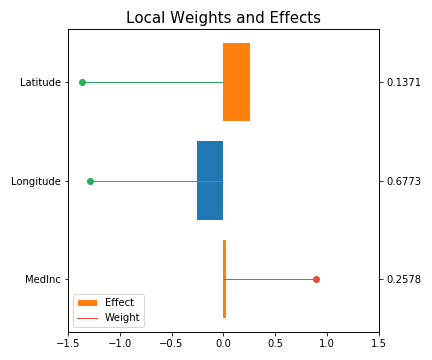

In [20]:
exp.model_explain(model='GAMI-Net', show='lime', sample_id=0, figsize=(6, 5))

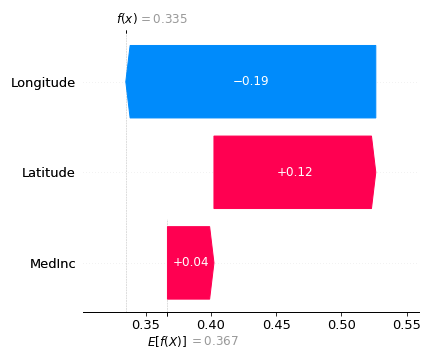

In [21]:
exp.model_explain(model='EBM', show='shap_waterfall', sample_id=0, figsize=(6, 5))

## Inherent Interpretation: Global and Local Methods

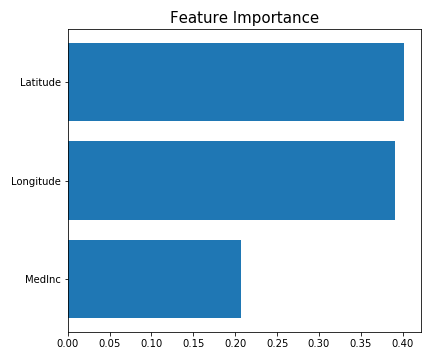

In [22]:
exp.model_interpret(model='GAMI-Net', show='global_fi', figsize=(6, 5))

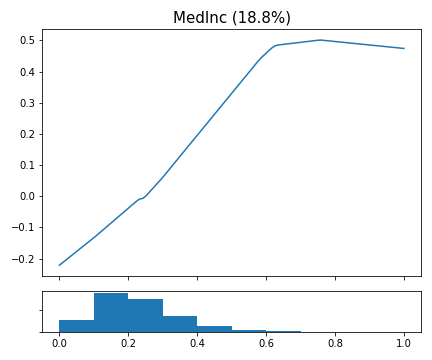

In [23]:
exp.model_interpret(model='GAMI-Net', show='global_effect_plot', uni_feature='MedInc', figsize=(6, 5))

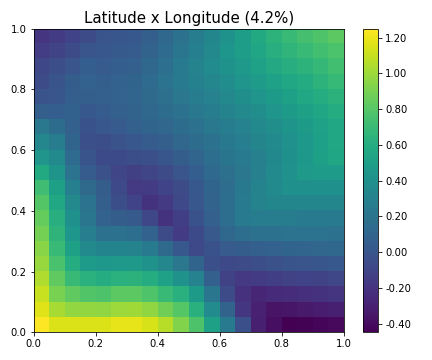

In [24]:
exp.model_interpret(model='GAMI-Net', show='global_effect_plot', 
                    bi_features=['Longitude', 'Latitude'], figsize=(6, 5))

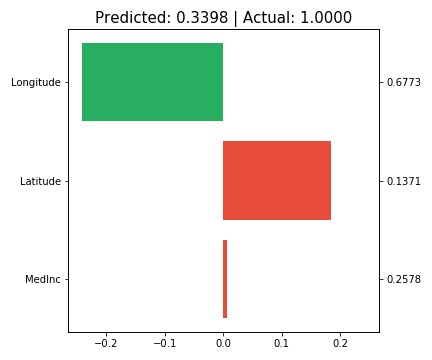

In [25]:
exp.model_interpret(model='GAMI-Net', show='local_fi', sample_id=0, figsize=(6, 5))

# Stage 4. Diagnose and Compare

In [26]:
exp.model_diagnose(model='GAMI-Net', show='accuracy_table')

,MSE,MAE,R2
,,,
Train,0.0169,0.0908,0.7024
Test,0.0174,0.0922,0.6865
Gap,0.0004,0.0014,-0.0159


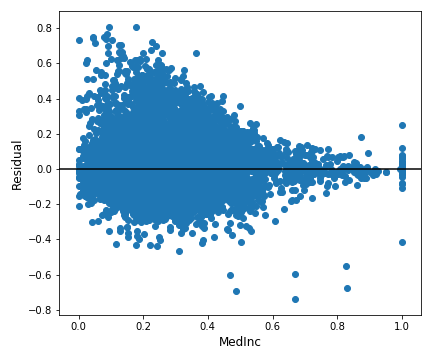

In [27]:
exp.model_diagnose(model='GAMI-Net', show='accuracy_residual', target_feature='MedInc', figsize=(6, 5))

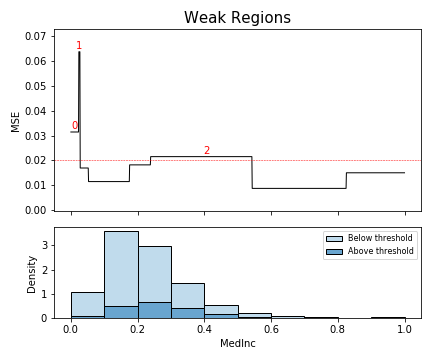

In [28]:
exp.model_diagnose(model='GAMI-Net', show='weakspot', slice_features=['MedInc'], 
                   slice_method='tree', threshold=1.2, min_samples=20, figsize=(6, 5))

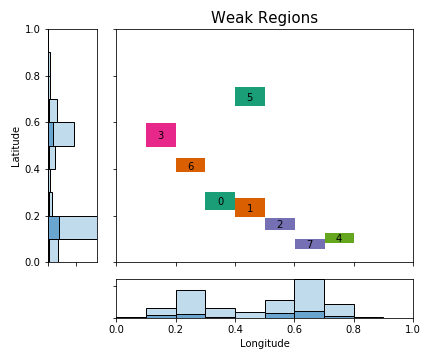

In [29]:
exp.model_diagnose(model='GAMI-Net', show='weakspot', slice_features=['Longitude', 'Latitude'], 
                   slice_method='histogram', threshold=1.2, min_samples=20, figsize=(6, 5))

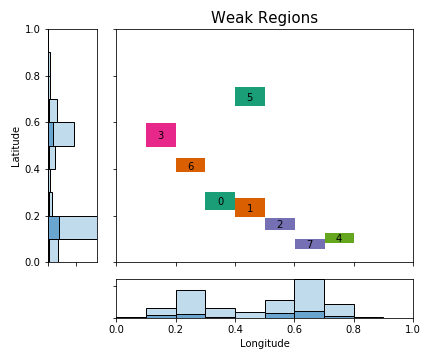

In [30]:
exp.model_diagnose(model='GAMI-Net', show='weakspot', slice_features=['Longitude', 'Latitude'], 
                   slice_method='histogram', threshold=1.2, min_samples=20, figsize=(6, 5))

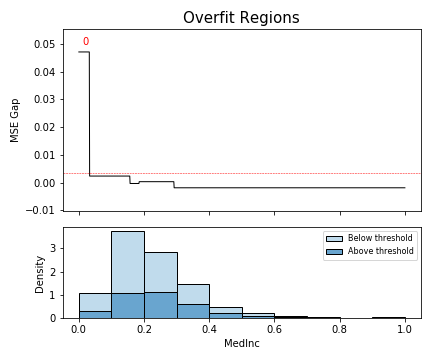

In [31]:
exp.model_diagnose(model='GAMI-Net', show='overfit', slice_features=['MedInc'], 
                   slice_method='tree', threshold=1.2, min_samples=20, figsize=(6, 5))

In [32]:
exp.model_diagnose(model='GAMI-Net', show='reliability_table', alpha=0.1)

,Empirical Coverage,Average Bandwidth
0,0.893398,0.348713


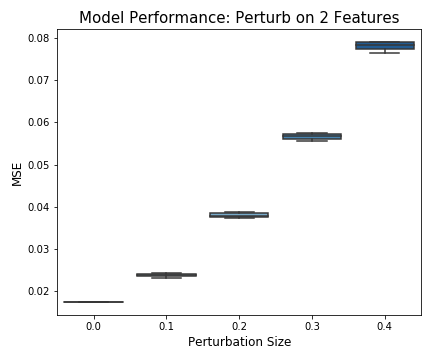

In [33]:
exp.model_diagnose(model='GAMI-Net', show='robustness_perf', perturb_features=["Longitude", "Latitude"],
                   perturb_size=0.1, figsize=(6, 5))

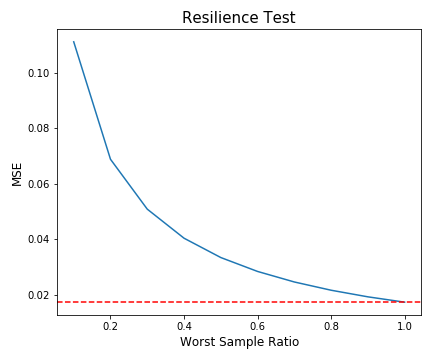

In [34]:
exp.model_diagnose(model='GAMI-Net', show='resilience_perf', figsize=(6, 5))

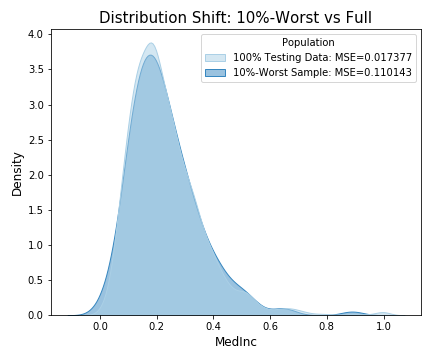

In [35]:
exp.model_diagnose(model='GAMI-Net', show='resilience_shift_density', immu_feature='MedInc', 
                   target_feature='MedInc', alpha=0.1, figsize=(6, 5))

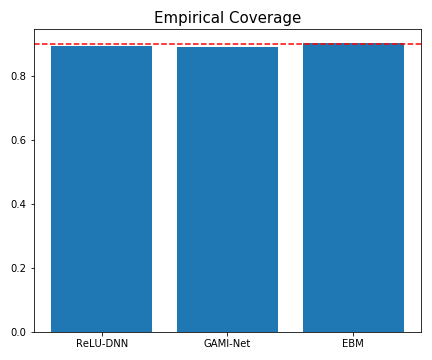

In [36]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='reliability_coverage', figsize=(6, 5))

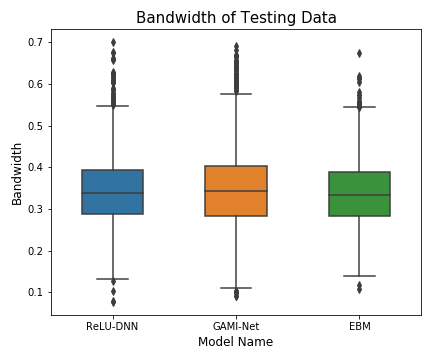

In [37]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='reliability_bandwidth', figsize=(6, 5))

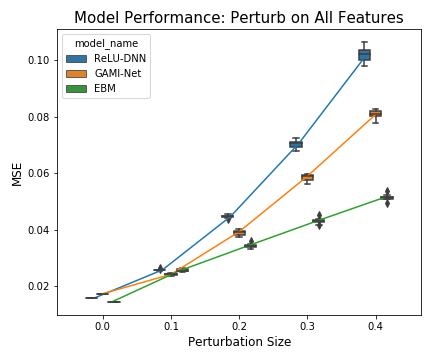

In [38]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='robustness_perf', figsize=(6, 5))

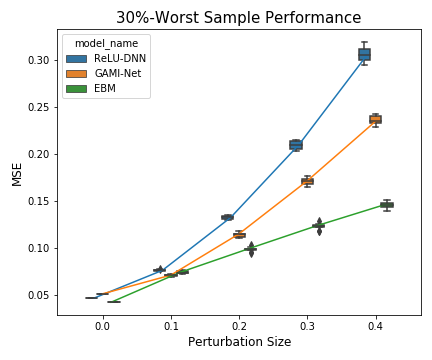

In [39]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='robustness_perf_worst', alpha=0.3, figsize=(6, 5))

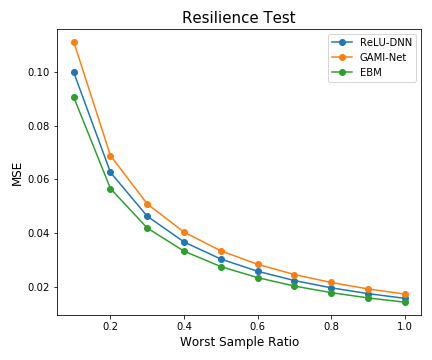

In [40]:
exp.model_compare(models=['ReLU-DNN','GAMI-Net', 'EBM'], show='resilience_perf', figsize=(6, 5))

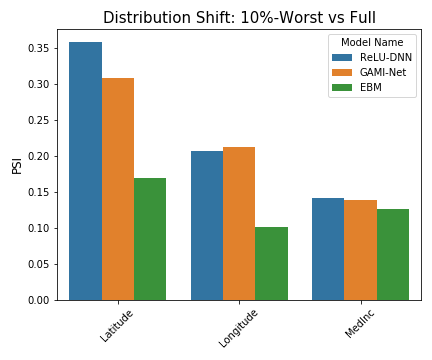

In [41]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='resilience_distance', figsize=(6, 5))